<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 2: Singapore Housing Modelling -Testing Code

**Information about notebook:**

The purpose of this notebook is mainly used for the fitting of the chosen regression model onto the unseen test data to generate predicted resale prices and importing them into a csv file for submission onto Kaggle.
 
It will contain only the essential codes required from importing of packages and the train data, to fitting of the model onto the unseen test data. There will be no markdown cells for the explaination of rationale nor EDA plots in this notebook. For further details of the rationale through the different sections, necessary explainations, exploratory plots and summary, please refer to "final_constance_main_code_project2.ipynb".

### 1. Importing packages & data

In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# modelling imports
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import statsmodels.api as sm

In [2]:
# Load the trained model
model_ridgecv = joblib.load("./trained.pkl") 

# read csv for test data
df_hdb = pd.read_csv("../data/test.csv")

# see rows and columns; and details of first 5 rows
print(df_hdb.shape)
df_hdb.head(2)

(16737, 76)


C:\Users\const\AppData\Local\Temp\ipykernel_13420\23188639.py:5: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hdb = pd.read_csv("../data/test.csv")


,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,...,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,...,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098


In [3]:
# to create a record of the original list of ID before we do data processing
# this is to ensure we do not loose the original set of IDs that we will require for submission to kaggle
test_original_id = df_hdb[['id']].copy()
test_original_id.head()
len(test_original_id)

16737

In [4]:
# check info for each column
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 76 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16737 non-null  int64  
 1   Tranc_YearMonth            16737 non-null  object 
 2   town                       16737 non-null  object 
 3   flat_type                  16737 non-null  object 
 4   block                      16737 non-null  object 
 5   street_name                16737 non-null  object 
 6   storey_range               16737 non-null  object 
 7   floor_area_sqm             16737 non-null  float64
 8   flat_model                 16737 non-null  object 
 9   lease_commence_date        16737 non-null  int64  
 10  Tranc_Year                 16737 non-null  int64  
 11  Tranc_Month                16737 non-null  int64  
 12  mid_storey                 16737 non-null  int64  
 13  lower                      16737 non-null  int

### 2. Data cleaning

In [5]:
# change column names to all lower case for uniformity sake
df_hdb = df_hdb.rename(columns=str.lower)

#### (a) Handling NaNs in data

In [6]:
# inspect postal column for nils with all columns shown
# to show all columns and not truncate them 
pd.set_option("display.max_columns", 80)
df_hdb[df_hdb["postal"] == "NIL"]

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
5137,162636,2016-07,SENGKANG,4 ROOM,238,COMPASSVALE WALK,16 TO 18,100.0,Model A,1999,2016,7,17,16,18,17,4 ROOM Model A,"238, COMPASSVALE WALK",1076.400,22,16,1998,Y,N,N,N,N,137,0,0,0,92,45,0,0,0,0,0,0,0,NIL,1.39044,103.898664,Sengkang,448.929181,1.0,3.0,6.0,2449.012307,NaN,NaN,NaN,40,0,394.275271,Sengkang,1,1,1.39244,103.895735,117.388688,Blk 240,1.391018,103.89778,163.462621,Seng Kang Primary School,87,0,1.38925,103.899528,459.867211,CHIJ Saint Joseph's Convent,232,0,1.391781,103.902577
10755,162652,2015-05,SENGKANG,5 ROOM,238,COMPASSVALE WALK,16 TO 18,122.0,Improved,1999,2015,5,17,16,18,17,5 ROOM Improved,"238, COMPASSVALE WALK",1313.208,22,16,1998,Y,N,N,N,N,137,0,0,0,92,45,0,0,0,0,0,0,0,NIL,1.39044,103.898664,Sengkang,448.929181,1.0,3.0,6.0,2449.012307,NaN,NaN,NaN,40,0,394.275271,Sengkang,1,1,1.39244,103.895735,117.388688,Blk 240,1.391018,103.89778,163.462621,Seng Kang Primary School,87,0,1.38925,103.899528,459.867211,CHIJ Saint Joseph's Convent,232,0,1.391781,103.902577


In [7]:
# fill in the postal code for the missing places since only 2 locations
# we can easily find the postal code based on the address and block numbers
df_hdb.loc[df_hdb["address"] == "215, CHOA CHU KANG CTRL", "postal"] = "680215"
df_hdb.loc[df_hdb["address"] == "238, COMPASSVALE WALK", "postal"] = "540238"

In [8]:
# check if they are all filled in
# searching for NIL should return no results
df_hdb[df_hdb["postal"] == "NIL"]

,id,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude


In [9]:
# inspect mall nearest distance column for blank fields
df_hdb["mall_nearest_distance"].replace("",np.NaN)
print(df_hdb["mall_nearest_distance"].isnull().sum())

# drop these rows as we cannot estimate the distances to impute accurate values in
df_hdb.dropna(subset = ["mall_nearest_distance"], inplace = True)

84


In [10]:
# check shape to see if 829 rows are dropped
df_hdb.shape

(16653, 76)

In [11]:
# inspected csv and found nan values for the following columns
# check the columns out to confirm
print(df_hdb["mall_within_500m"].unique())
print(df_hdb["mall_within_1km"].unique())
print(df_hdb["mall_within_2km"].unique())
print(df_hdb["hawker_within_500m"].unique())
print(df_hdb["hawker_within_1km"].unique())
print(df_hdb["hawker_within_2km"].unique())

[nan  1.  2.  4.  3.  5.  6.]
[ 2.  1. nan  4.  3.  5.  7.  6.  8. 13. 12. 11. 15. 10.  9. 14.]
[ 4.  3.  5.  2.  6. 12.  7.  8.  1. 11. 10.  9. 21. nan 14. 31. 30. 38.
 35. 27. 28. 26. 19. 24. 25. 29. 23. 15. 22. 20. 18. 17. 13. 34. 33. 32.
 16. 43. 42. 39. 37.]
[nan  1.  3.  2.  4.  5.]
[ 1. nan  3.  2.  5.  4.  6.  9.  8.  7.]
[ 1. nan 11.  2.  8. 12.  5. 10.  4.  3.  7.  9.  6. 13. 14. 16. 15. 17.
 18. 19.]


In [12]:
# fill NaNs with 0 
df_hdb.fillna(0, inplace=True)

In [13]:
# to confirm NaNs replaced with 0 successfully
print(df_hdb["mall_within_500m"].unique())
print(df_hdb["mall_within_1km"].unique())
print(df_hdb["mall_within_2km"].unique())
print(df_hdb["hawker_within_500m"].unique())
print(df_hdb["hawker_within_1km"].unique())
print(df_hdb["hawker_within_2km"].unique())

[0. 1. 2. 4. 3. 5. 6.]
[ 2.  1.  0.  4.  3.  5.  7.  6.  8. 13. 12. 11. 15. 10.  9. 14.]
[ 4.  3.  5.  2.  6. 12.  7.  8.  1. 11. 10.  9. 21.  0. 14. 31. 30. 38.
 35. 27. 28. 26. 19. 24. 25. 29. 23. 15. 22. 20. 18. 17. 13. 34. 33. 32.
 16. 43. 42. 39. 37.]
[0. 1. 3. 2. 4. 5.]
[1. 0. 3. 2. 5. 4. 6. 9. 8. 7.]
[ 1.  0. 11.  2.  8. 12.  5. 10.  4.  3.  7.  9.  6. 13. 14. 16. 15. 17.
 18. 19.]


#### (b) Converting column values to boolean

In [14]:
# change columns 23 -27 to boolean values for uniformity through our dataset
# Y = 1 , N = 0

df_hdb["residential"] = df_hdb["residential"].map({'Y': 1, 'N': 0})
df_hdb["commercial"] = df_hdb["commercial"].map({'Y': 1, 'N': 0})
df_hdb["market_hawker"] = df_hdb["market_hawker"].map({'Y': 1, 'N': 0})
df_hdb["multistorey_carpark"] = df_hdb["multistorey_carpark"] .map({'Y': 1, 'N': 0})
df_hdb["precinct_pavilion"] = df_hdb["precinct_pavilion"].map({'Y': 1, 'N': 0})

In [15]:
# change all rental to boolean values
# have rental units = 1, no rental units = 0
has_rental = (df_hdb[['1room_rental', '2room_rental', '3room_rental', 'other_room_rental']].sum(axis=1) > 0).astype(int) 
df_hdb.insert(loc = 1, column = "rental_units_in_blk", value = has_rental)

In [16]:
# check the df for new column "rental_units_in_blk" and respective columns in boolean instead of Y/N
pd.set_option("display.max_columns", 80)
df_hdb.head()

,id,rental_units_in_blk,tranc_yearmonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,tranc_year,tranc_month,mid_storey,lower,upper,mid,full_flat_type,address,floor_area_sqft,hdb_age,max_floor_lvl,year_completed,residential,commercial,market_hawker,multistorey_carpark,precinct_pavilion,total_dwelling_units,1room_sold,2room_sold,3room_sold,4room_sold,5room_sold,exec_sold,multigen_sold,studio_apartment_sold,1room_rental,2room_rental,3room_rental,other_room_rental,postal,latitude,longitude,planning_area,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,mrt_name,bus_interchange,mrt_interchange,mrt_latitude,mrt_longitude,bus_stop_nearest_distance,bus_stop_name,bus_stop_latitude,bus_stop_longitude,pri_sch_nearest_distance,pri_sch_name,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,114982,0,2012-11,YISHUN,4 ROOM,173,YISHUN AVE 7,07 TO 09,84.0,Simplified,1987,2012,11,8,7,9,8,4 ROOM Simplified,"173, YISHUN AVE 7",904.176,34,12,1986,1,1,0,0,0,132,0,0,0,92,40,0,0,0,0,0,0,0,760173,1.437066,103.831121,Yishun,877.431572,0.0,2.0,4.0,687.576779,0.0,1.0,1.0,56,123,686.660434,Canberra,0,0,1.443077,103.829703,75.683952,Blk 174,1.437558,103.831591,426.467910,Ahmad Ibrahim Primary School,92,0,1.433681,103.832924,156.322353,Ahmad Ibrahim Secondary School,218,0,1.436235,103.829987
1,95653,0,2019-08,JURONG WEST,5 ROOM,986C,JURONG WEST ST 93,04 TO 06,112.0,Premium Apartment,2008,2019,8,5,4,6,5,5 ROOM Premium Apartment,"986C, JURONG WEST ST 93",1205.568,13,14,2002,1,0,0,0,0,53,0,0,0,28,25,0,0,0,0,0,0,0,643986,1.336957,103.695668,Jurong West,534.037705,0.0,1.0,3.0,2122.346226,0.0,0.0,0.0,72,94,169.478175,Pioneer,0,0,1.337343,103.697143,88.993058,Blk 653B,1.336491,103.696319,439.756851,Jurong West Primary School,45,0,1.339244,103.698896,739.371688,Jurong West Secondary School,199,0,1.335256,103.702098
2,40303,1,2013-10,ANG MO KIO,3 ROOM,534,ANG MO KIO AVE 10,07 TO 09,68.0,New Generation,1980,2013,10,8,7,9,8,3 ROOM New Generation,"534, ANG MO KIO AVE 10",731.952,41,12,1979,1,0,0,0,0,218,0,0,191,22,1,1,0,0,0,0,3,0,560534,1.374058,103.854168,Ang Mo Kio,817.050453,0.0,2.0,3.0,152.287621,1.0,3.0,11.0,50,100,694.220448,Ang Mo Kio,1,0,1.369465,103.849939,86.303575,Blk 532,1.374255,103.854919,355.882207,Jing Shan Primary School,36,0,1.371893,103.851811,305.071191,Anderson Secondary School,245,0,1.374242,103.851430
3,109506,0,2017-10,WOODLANDS,4 ROOM,29,MARSILING DR,01 TO 03,97.0,New Generation,1979,2017,10,2,1,3,2,4 ROOM New Generation,"29, MARSILING DR",1044.108,42,14,1976,1,0,0,0,0,104,0,0,0,104,0,0,0,0,0,0,0,0,731029,1.442748,103.772922,Woodlands,1272.737194,0.0,0.0,3.0,501.892158,0.0,1.0,2.0,52,112,1117.203587,Marsiling,0,0,1.432757,103.773982,108.459039,Blk 32,1.443650,103.773295,929.744711,Marsiling Primary School,54,0,1.434423,103.773698,433.454591,Woodlands Secondary School,188,0,1.439183,103.774499
4,100149,0,2016-08,BUKIT BATOK,4 ROOM,170,BT BATOK WEST AVE 8,16 TO 18,103.0,Model A,1985,2016,8,17,16,18,17,4 ROOM Model A,"170, BT BATOK WEST AVE 8",1108.692,36,25,1985,1,0,0,0,0,144,0,0,0,48,96,0,0,0,0,0,0,0,650170,1.346556,103.740101,Bukit Batok,1070.963675,0.0,0.0,5.0,437.593564,1.0,2.0,2.0,60,87,987.976010,Chinese Garden,0,0,1.342441,103.732225,113.645431,Blk 169,1.346899,103.741064,309.926934,Princess Elizabeth Primary School,40,0,1.349195,103.741000,217.295361,Bukit Batok Secondary School,223,0,1.348351,103.740873


#### (c) Converting column values to the correct dtype

In [17]:
# convert tranc_month to object 
df_hdb["tranc_month"] = df_hdb["tranc_month"].astype("object")

In [18]:
# convert id to object 
df_hdb["id"] = df_hdb["id"].astype("object")

#### (d) Feature engineering of new column(s)

In [19]:
# create new column for hdb_age_left
# this is to show the remaining years left on the lease as of the year transacted
hdb_lease = (df_hdb["tranc_year"] - df_hdb["lease_commence_date"])
df_hdb.insert(loc = 1, column = "hdb_age_when_sold", value = hdb_lease)

In [20]:
# create new column for flat density
dwelling = (df_hdb["total_dwelling_units"] / df_hdb["max_floor_lvl"])
df_hdb.insert(loc = 1, column = "dwelling_density", value = dwelling)

#### (e) Reorganizing categories in flat_model and town columns

In [21]:
# reorganise flat models into bigger categories
regrouped_values = {"Model A": "Model A",
                  "Improved": "Improved",
                  "New Generation": "New Generation",
                  "Premium Apartment": "Apartment",
                  "Simplified": "Simplified",
                  "Apartment": "Apartment",
                  "Standard": "Standard",
                  "Maisonette": "Maisonette",
                  "Model A2": "Model A",
                  "DBSS": "DBSS",
                  "Model A-Maisonette": "Maisonette",
                  "Adjoined flat": "Adjoined flat",
                  "Type S1": "Type S",
                  "Type S2": "Type S",
                  "Terrace" : "Terrace",
                  "Premium Apartment Loft": "Maisonette",
                  "Improved-Maisonette": "Maisonette",
                  "Premium Maisonette": "Maisonette",
                  "2-room": "2-room"}

df_hdb = df_hdb.replace({'flat_model': regrouped_values})

# see updated categories of flat models
df_hdb['flat_model'].unique()

array(['Simplified', 'Apartment', 'New Generation', 'Model A', 'Improved',
       'Standard', 'Maisonette', 'DBSS', 'Adjoined flat',
       'Multi Generation', 'Type S', 'Terrace'], dtype=object)

In [22]:
# reorganise town into bigger categories

town_region_mapping = {"SEMBAWANG": "north",
                  "WOODLANDS": "north",
                  "YISHUN": "north",
                  "ANG MO KIO": "north-east mature",
                  "HOUGANG": "north-east",
                  "PUNGGOL": "north-east",
                  "SENGKANG": "north-east",
                  "SERANGOON": "north-east mature",
                  "BEDOK": "east mature",
                  "PASIR RIS": "east mature",
                  "TAMPINES": "east mature",
                  "BUKIT BATOK": "west",
                  "BUKIT PANJANG": "west",
                  "CHOA CHU KANG": "west",
                  "CLEMENTI": "west mature",
                  "JURONG EAST": "west",
                  "JURONG WEST": "west",
                  "BISHAN": "central mature",
                  "BUKIT MERAH": "central mature",
                  "BUKIT TIMAH": "central mature",
                  "CENTRAL AREA": "central mature",
                  "GEYLANG": "central mature",
                  "KALLANG/WHAMPOA": "central mature",
                  "MARINE PARADE": "central mature",
                  "QUEENSTOWN": "central mature",
                  "TOA PAYOH": "central mature"
                }
town_region = df_hdb["town"].map(town_region_mapping)
df_hdb.insert(loc = 1, column = "town_region", value = town_region)

#### (f) Dropping of unncessary columns from the dataframe

In [23]:
# drop columns that show correlated information/ not useful to be a feature based on first understanding of data dictionary

df_hdb.drop(["tranc_yearmonth","block","street_name","address", "postal", 
             "latitude", "longitude", "planning_area","lease_commence_date","hdb_age",
             "year_completed","floor_area_sqm","full_flat_type","total_dwelling_units","max_floor_lvl",
             "1room_sold","2room_sold","3room_sold","4room_sold","5room_sold",
             "exec_sold","multigen_sold","studio_apartment_sold","1room_rental","2room_rental",
             "3room_rental","other_room_rental","mrt_name","mrt_latitude","mrt_longitude",
             "bus_stop_name","bus_stop_latitude","bus_stop_longitude","pri_sch_name","pri_sch_latitude",
             "pri_sch_longitude","sec_sch_name","sec_sch_longitude","sec_sch_latitude","market_hawker",
             "storey_range","town"],
             axis='columns', inplace=True) 


# check shape to ensure columns dropped 
df_hdb.shape

(16653, 38)

In [24]:
pd.set_option("display.max_columns", 80)
df_hdb.head(2)

,id,town_region,dwelling_density,hdb_age_when_sold,rental_units_in_blk,flat_type,flat_model,tranc_year,tranc_month,mid_storey,lower,upper,mid,floor_area_sqft,residential,commercial,multistorey_carpark,precinct_pavilion,mall_nearest_distance,mall_within_500m,mall_within_1km,mall_within_2km,hawker_nearest_distance,hawker_within_500m,hawker_within_1km,hawker_within_2km,hawker_food_stalls,hawker_market_stalls,mrt_nearest_distance,bus_interchange,mrt_interchange,bus_stop_nearest_distance,pri_sch_nearest_distance,vacancy,pri_sch_affiliation,sec_sch_nearest_dist,cutoff_point,affiliation
0,114982,north,11.000000,25,0,4 ROOM,Simplified,2012,11,8,7,9,8,904.176,1,1,0,0,877.431572,0.0,2.0,4.0,687.576779,0.0,1.0,1.0,56,123,686.660434,0,0,75.683952,426.467910,92,0,156.322353,218,0
1,95653,west,3.785714,11,0,5 ROOM,Apartment,2019,8,5,4,6,5,1205.568,1,0,0,0,534.037705,0.0,1.0,3.0,2122.346226,0.0,0.0,0.0,72,94,169.478175,0,0,88.993058,439.756851,45,0,739.371688,199,0


In [25]:
# check updated info on df after initial data cleaning
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16653 entries, 0 to 16736
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16653 non-null  object 
 1   town_region                16653 non-null  object 
 2   dwelling_density           16653 non-null  float64
 3   hdb_age_when_sold          16653 non-null  int64  
 4   rental_units_in_blk        16653 non-null  int32  
 5   flat_type                  16653 non-null  object 
 6   flat_model                 16653 non-null  object 
 7   tranc_year                 16653 non-null  int64  
 8   tranc_month                16653 non-null  object 
 9   mid_storey                 16653 non-null  int64  
 10  lower                      16653 non-null  int64  
 11  upper                      16653 non-null  int64  
 12  mid                        16653 non-null  int64  
 13  floor_area_sqft            16653 non-null  float64


### 3. Initial EDA

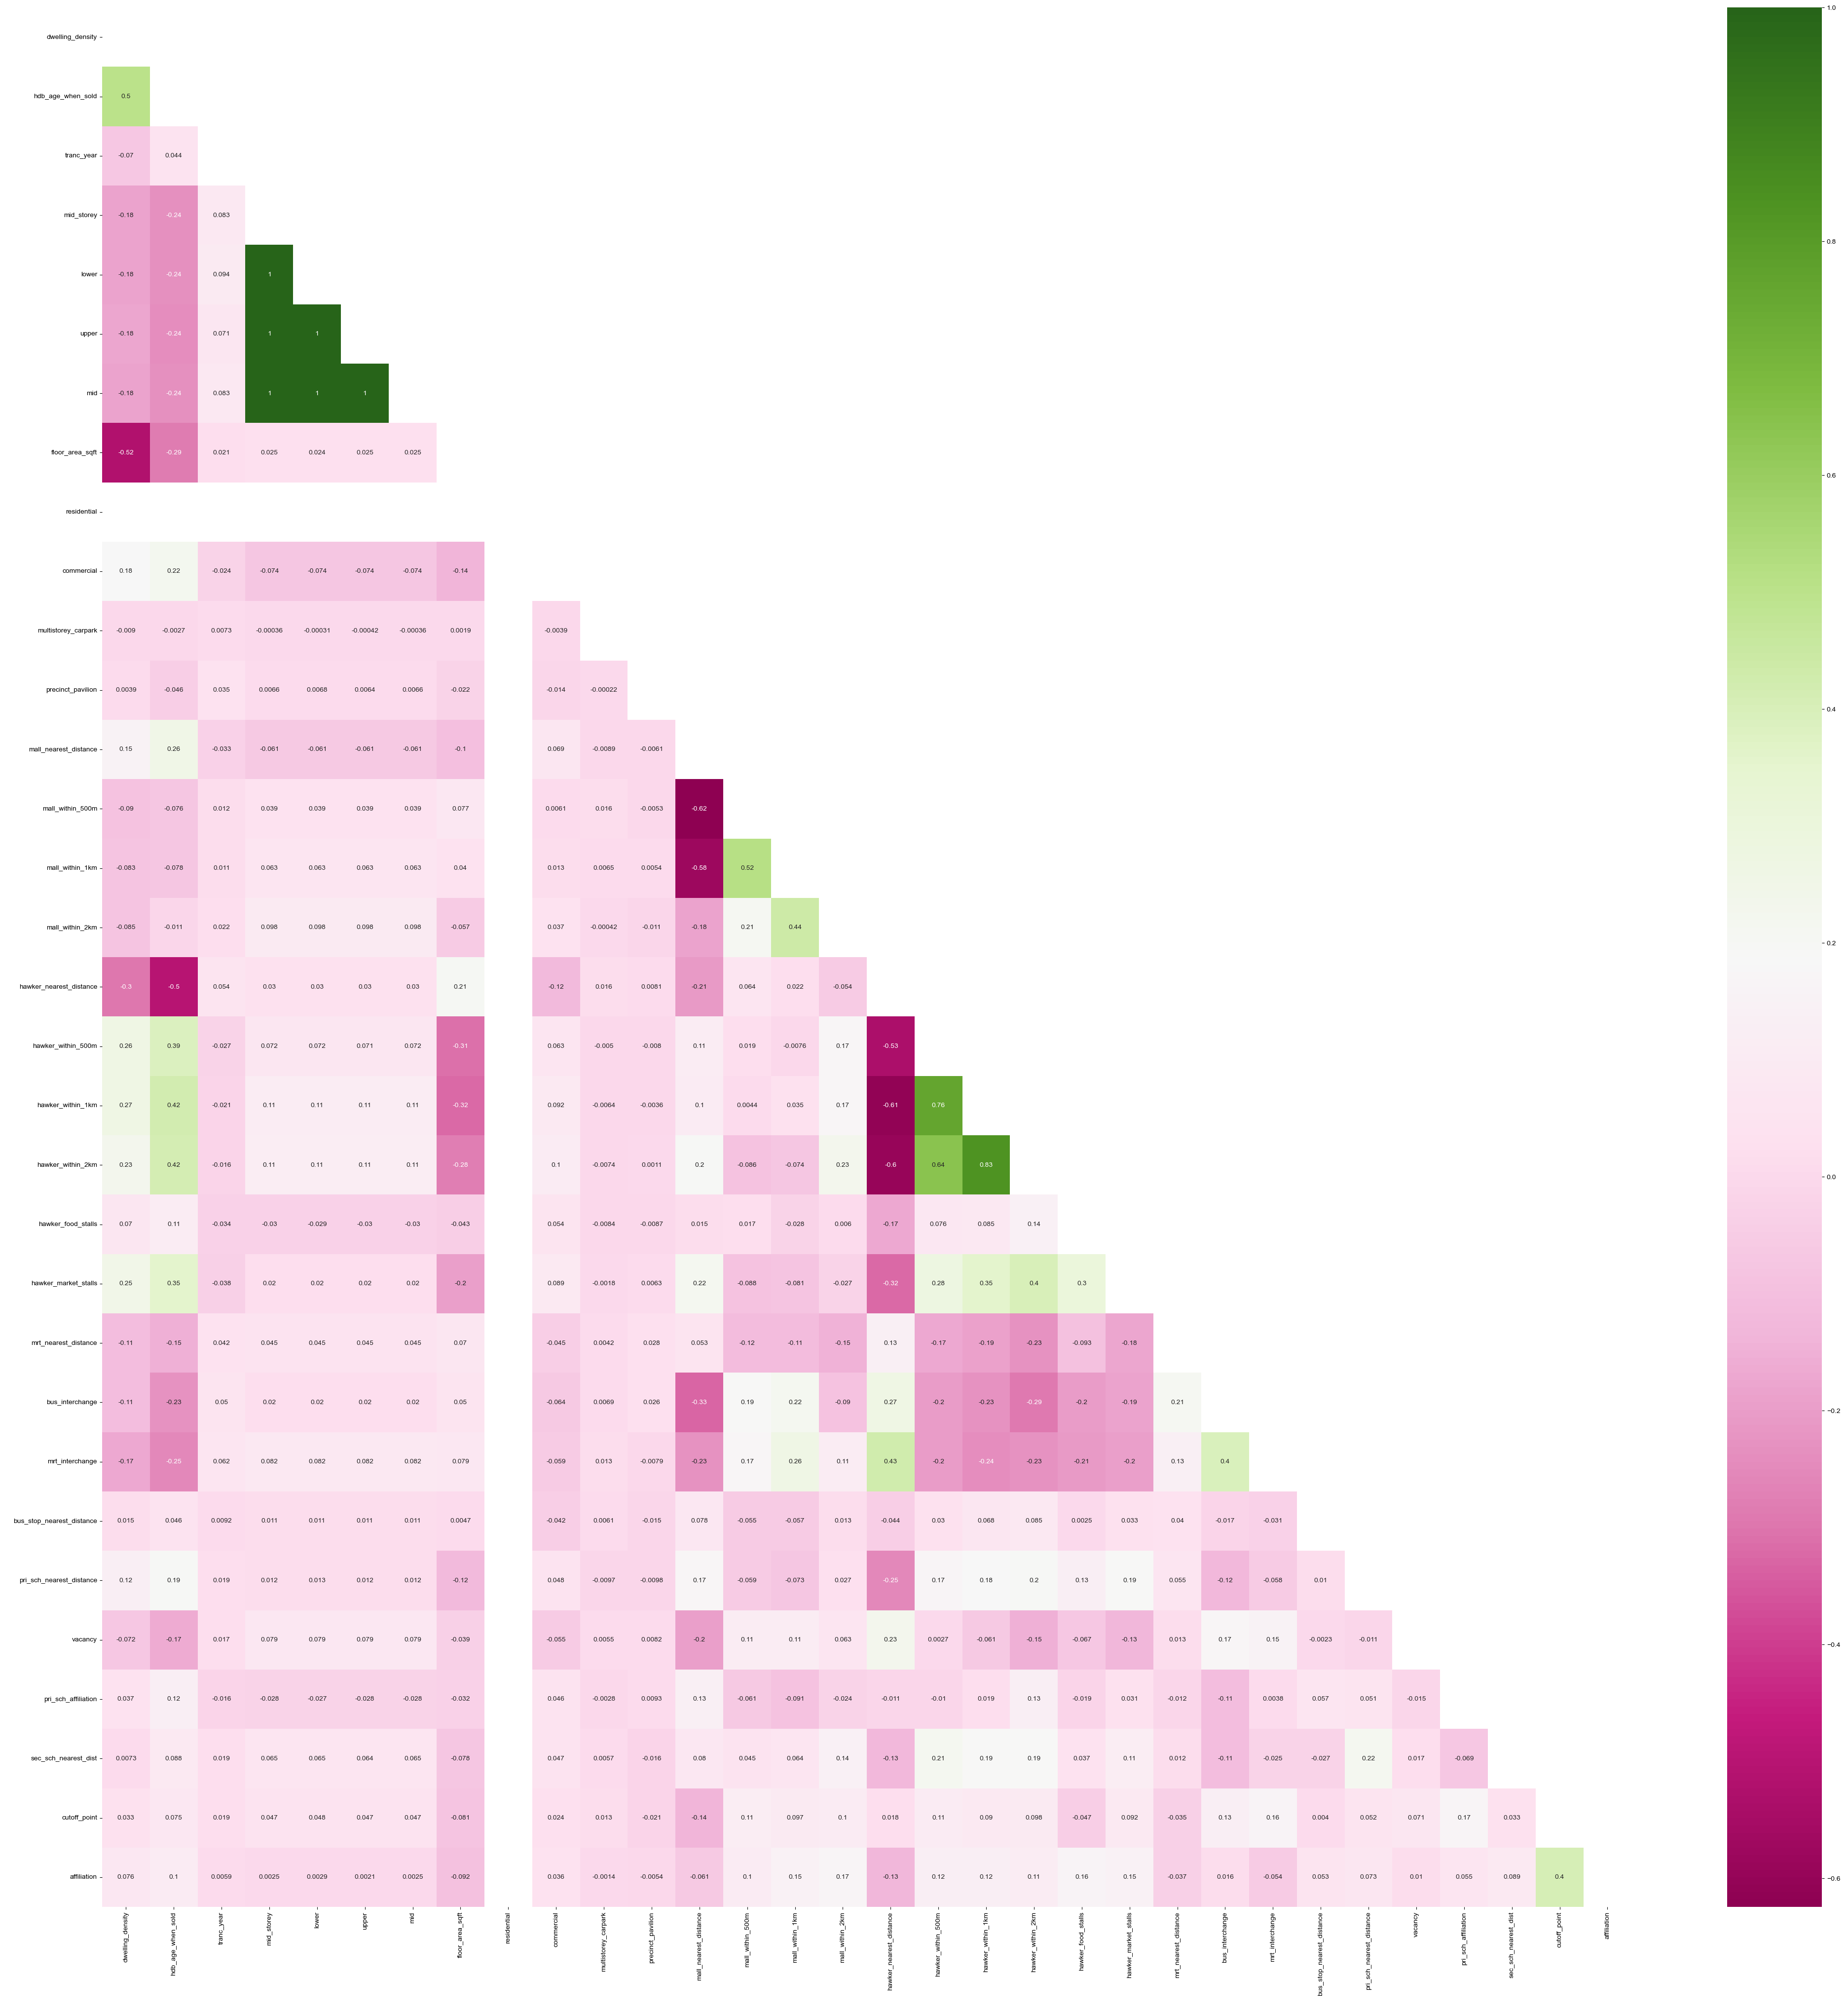

In [26]:
# to do initial correlation heatmap to see possible correlation between remaining numerical variables
# set up mask to be "True" in the upper triangle since it will be symmetrical

mask = np.zeros_like(df_hdb.select_dtypes(include=["int64","float64"]).corr(numeric_only = True))
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (50,50))
sns.heatmap(df_hdb.select_dtypes(include=["int64","float64"]).corr(numeric_only=True), mask = mask, annot = True, cmap="PiYG")
sns.set(rc={'figure.figsize':(50,50),
            "xtick.bottom" : True, "ytick.left" : True})

In [27]:
# drop further columns
df_hdb.drop(["lower","upper","mid","residential",
             "hawker_within_500m","hawker_within_1km",
             "mall_within_500m", "mall_within_1km"], axis='columns', inplace=True) 

# check shape to ensure columns dropped 
df_hdb.shape

(16653, 30)

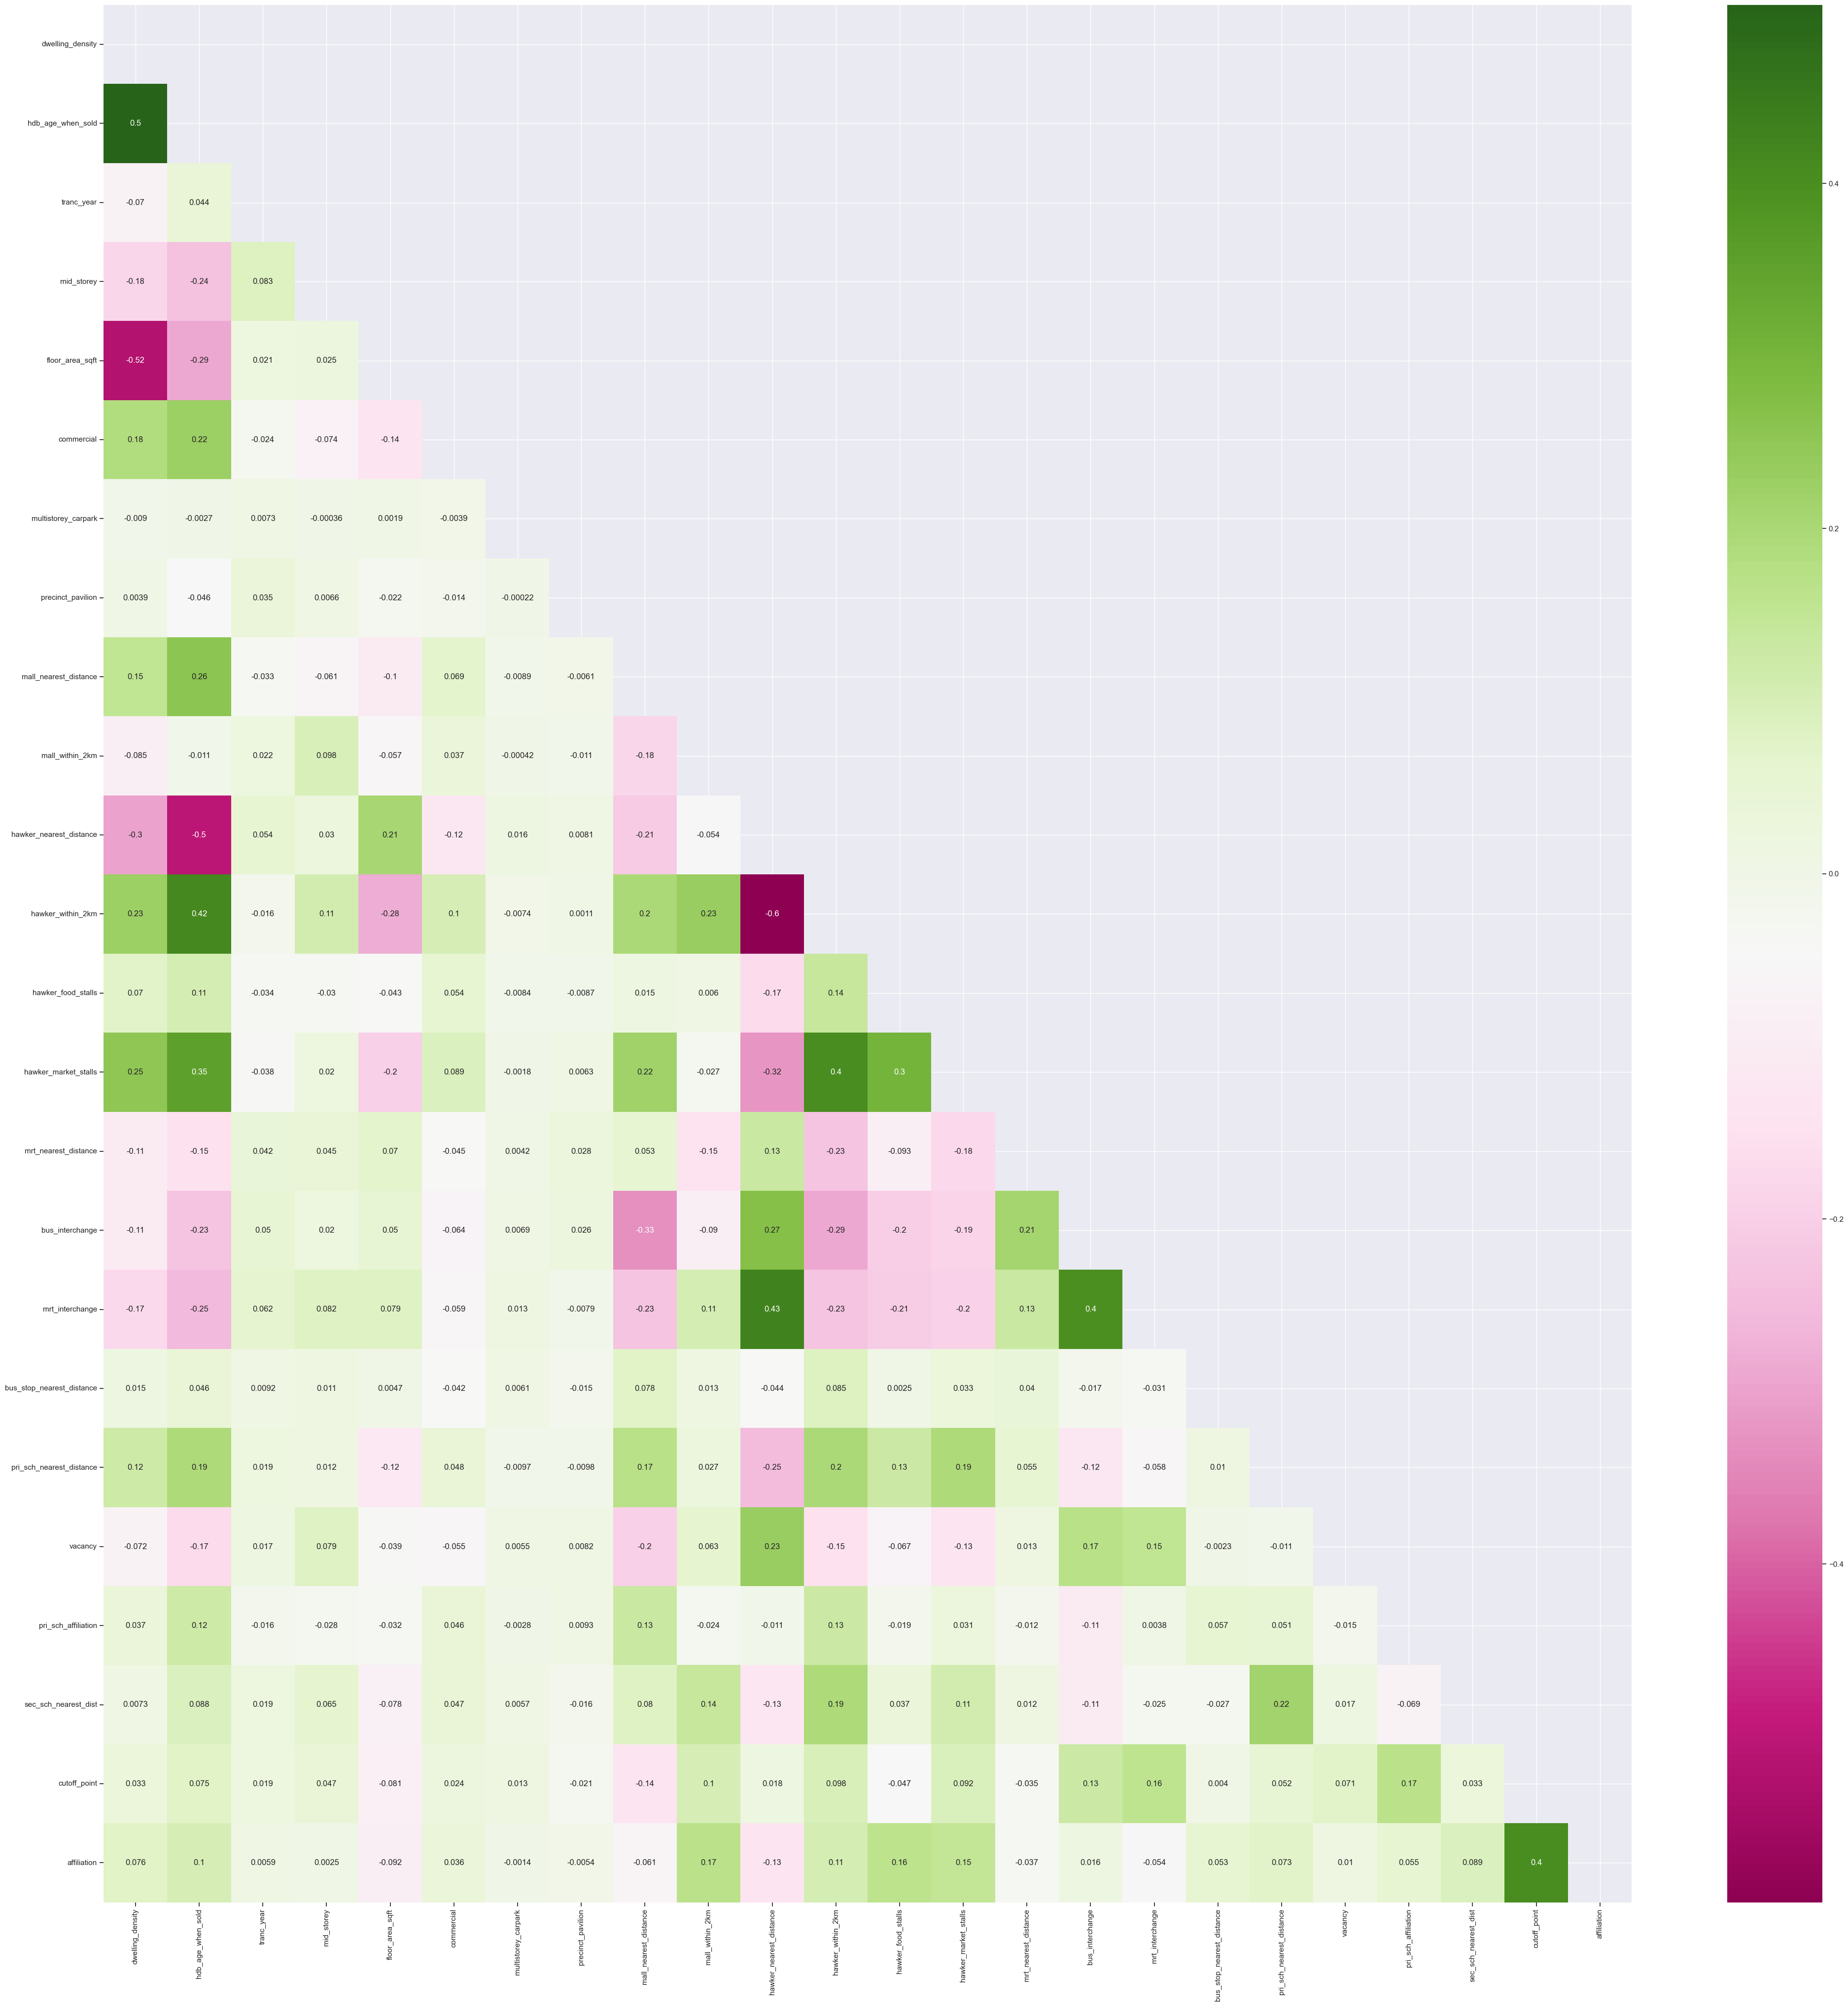

In [28]:
# recheck the heatmap
# set up mask to be "True" in the upper triangle since it will be symmetrical

mask = np.zeros_like(df_hdb.select_dtypes(include=["int64","float64"]).corr(numeric_only = True))
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (50,50))
sns.heatmap(df_hdb.select_dtypes(include=["int64","float64"]).corr(numeric_only=True), mask = mask, annot = True, cmap="PiYG")
sns.set(rc={'figure.figsize':(50,50),
            "xtick.bottom" : True, "ytick.left" : True})

In [29]:
# check the updated df info after second round of data cleaning
df_hdb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16653 entries, 0 to 16736
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         16653 non-null  object 
 1   town_region                16653 non-null  object 
 2   dwelling_density           16653 non-null  float64
 3   hdb_age_when_sold          16653 non-null  int64  
 4   rental_units_in_blk        16653 non-null  int32  
 5   flat_type                  16653 non-null  object 
 6   flat_model                 16653 non-null  object 
 7   tranc_year                 16653 non-null  int64  
 8   tranc_month                16653 non-null  object 
 9   mid_storey                 16653 non-null  int64  
 10  floor_area_sqft            16653 non-null  float64
 11  commercial                 16653 non-null  int64  
 12  multistorey_carpark        16653 non-null  int64  
 13  precinct_pavilion          16653 non-null  int64  


### 4. Further EDA

In [30]:
# summary statistics
# catgorical columns not included 
df_hdb.describe().T

,count,mean,std,min,25%,50%,75%,max
dwelling_density,16653.0,8.834292,4.150890,1.000000,5.733333,7.760000,10.909091,45.363636
hdb_age_when_sold,16653.0,24.218940,11.889575,1.000000,15.000000,25.000000,33.000000,54.000000
rental_units_in_blk,16653.0,0.037711,0.190502,0.000000,0.000000,0.000000,0.000000,1.000000
tranc_year,16653.0,2016.440942,2.735159,2012.000000,2014.000000,2017.000000,2019.000000,2021.000000
mid_storey,16653.0,8.257791,5.476317,2.000000,5.000000,8.000000,11.000000,50.000000
floor_area_sqft,16653.0,1043.507522,263.483849,333.684000,796.536000,1022.580000,1205.568000,2863.224000
commercial,16653.0,0.199063,0.399308,0.000000,0.000000,0.000000,0.000000,1.000000
multistorey_carpark,16653.0,0.000060,0.007749,0.000000,0.000000,0.000000,0.000000,1.000000
precinct_pavilion,16653.0,0.000841,0.028983,0.000000,0.000000,0.000000,0.000000,1.000000
mall_nearest_distance,16653.0,661.499676,367.280337,0.000000,389.431001,601.947831,866.929405,3496.402910


#### (a) Explore relationship of flat type and resale price - to drop further categories deemed necessary

In [31]:
# filter out 1 room and multigeneration from flat type
print(f'Numbr of 1 room and  multigeneration flats: {len(df_hdb.loc[(df_hdb["flat_type"] == "1 ROOM") | (df_hdb["flat_type"] == "MULTI-GENERATION")])}')
df_hdb.shape

Numbr of 1 room and  multigeneration flats: 15


(16653, 30)

In [32]:
# drop them from df
df_hdb.drop(df_hdb[df_hdb["flat_type"] == "1 ROOM"].index, inplace = True)
df_hdb.drop(df_hdb[df_hdb["flat_type"] == "MULTI-GENERATION"].index, inplace = True)

print(df_hdb.shape)

(16638, 30)


#### (b) Explore relationship of flat model and resale price - to drop further categories deemed necessary

In [33]:
# drop 2-room from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "2-room"].index, inplace = True)

# drop adjoined flat from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "Adjoined flat"].index, inplace = True)

# check updated value counts for flat model
df_hdb["flat_model"].value_counts()

flat_model
Model A           5451
Improved          4179
New Generation    2552
Apartment         2339
Simplified         829
Standard           567
Maisonette         490
DBSS               150
Type S              41
Terrace             10
Name: count, dtype: int64

In [34]:
# drop them from df
df_hdb.drop(df_hdb[df_hdb["flat_model"] == "Terrace"].index, inplace = True)

print(df_hdb.shape)

(16598, 30)


In [35]:
# recategorise the type model into even broader categories
regrouped_values = {"Standard":"standard",
                    "New Generation":"standard",
                    "Simplified":"standard",
                    "Model A":"standard",
                    "Improved":"standard",
                    "Apartment":"standard",
                    "DBSS": "private built",
                    "Type S":"private built",
                    "Maisonette":"maisonette"
                    }

df_hdb = df_hdb.replace({'flat_model': regrouped_values})

# see updated categories of flat models
df_hdb['flat_model'].unique()

array(['standard', 'maisonette', 'private built'], dtype=object)

### 6. Modelling using Ridge regularization

In [36]:
# dumify our categorical columns
columns_to_dummify = ["town_region", "tranc_month", "flat_type", "flat_model"]
df_hdb = pd.get_dummies(columns = columns_to_dummify, drop_first = True, data = df_hdb)

In [37]:
# define our features and target variables
features = ["hdb_age_when_sold","tranc_year","mid_storey","floor_area_sqft","dwelling_density",
            "commercial","multistorey_carpark","precinct_pavilion","rental_units_in_blk","hawker_food_stalls",
            "hawker_nearest_distance","hawker_within_2km","mall_nearest_distance","mall_within_2km","hawker_market_stalls",
            "mrt_nearest_distance","bus_interchange","mrt_interchange","cutoff_point", "affiliation",
            "bus_stop_nearest_distance","pri_sch_nearest_distance","vacancy","pri_sch_affiliation","sec_sch_nearest_dist"] + [col for col in df_hdb if col.startswith(('tranc_month_', 'town_region_', 'flat_type_', 'flat_model_'))]

In [38]:
# dummified dataframe before modelling
df_hdb.head()
print(df_hdb.shape)

(16598, 49)


In [39]:
# create a record of the post-processed list of ID before we do modelling
# for us to merge the predicted resale prices to the respective IDs 
test_final_id = df_hdb[['id']].copy()
len(test_final_id)
type(test_final_id)

pandas.core.frame.DataFrame

In [40]:
# create our X and y variables
exclude_list = ["id"]
features = [col for col in df_hdb.columns if col not in exclude_list]

X = df_hdb[features]

In [41]:
# instantiate standard scaler to scale our data
ss = StandardScaler()

# fit and transform our X_train data
continuous_columns = ["hdb_age_when_sold","tranc_year","mid_storey","floor_area_sqft","dwelling_density",
                      "hawker_food_stalls","hawker_nearest_distance","hawker_within_2km","mall_nearest_distance","mall_within_2km",
                      "hawker_market_stalls","mrt_nearest_distance","cutoff_point","bus_stop_nearest_distance","pri_sch_nearest_distance",
                      "vacancy","sec_sch_nearest_dist"] 

# transform our X_test data
X[continuous_columns] = ss.fit_transform(X[continuous_columns])

C:\Users\const\AppData\Local\Temp\ipykernel_13420\2722708392.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[continuous_columns] = ss.fit_transform(X[continuous_columns])


### 7. Predicting resale prices

In [42]:
# check order of X columns
X.columns

Index(['dwelling_density', 'hdb_age_when_sold', 'rental_units_in_blk',
       'tranc_year', 'mid_storey', 'floor_area_sqft', 'commercial',
       'multistorey_carpark', 'precinct_pavilion', 'mall_nearest_distance',
       'mall_within_2km', 'hawker_nearest_distance', 'hawker_within_2km',
       'hawker_food_stalls', 'hawker_market_stalls', 'mrt_nearest_distance',
       'bus_interchange', 'mrt_interchange', 'bus_stop_nearest_distance',
       'pri_sch_nearest_distance', 'vacancy', 'pri_sch_affiliation',
       'sec_sch_nearest_dist', 'cutoff_point', 'affiliation',
       'town_region_east mature', 'town_region_north',
       'town_region_north-east', 'town_region_north-east mature',
       'town_region_west', 'town_region_west mature', 'tranc_month_2',
       'tranc_month_3', 'tranc_month_4', 'tranc_month_5', 'tranc_month_6',
       'tranc_month_7', 'tranc_month_8', 'tranc_month_9', 'tranc_month_10',
       'tranc_month_11', 'tranc_month_12', 'flat_type_3 ROOM',
       'flat_type_4 ROO

In [43]:
# reorder columns to be same as training data 
feature_order = ['hdb_age_when_sold', 'tranc_year', 'mid_storey', 'floor_area_sqft',
       'dwelling_density', 'commercial', 'multistorey_carpark',
       'precinct_pavilion', 'rental_units_in_blk', 'hawker_food_stalls',
       'hawker_nearest_distance', 'hawker_within_2km', 'mall_nearest_distance',
       'mall_within_2km', 'hawker_market_stalls', 'mrt_nearest_distance',
       'bus_interchange', 'mrt_interchange', 'cutoff_point', 'affiliation',
       'bus_stop_nearest_distance', 'pri_sch_nearest_distance', 'vacancy',
       'pri_sch_affiliation', 'sec_sch_nearest_dist',
       'town_region_east mature', 'town_region_north',
       'town_region_north-east', 'town_region_north-east mature',
       'town_region_west', 'town_region_west mature', 'tranc_month_2',
       'tranc_month_3', 'tranc_month_4', 'tranc_month_5', 'tranc_month_6',
       'tranc_month_7', 'tranc_month_8', 'tranc_month_9', 'tranc_month_10',
       'tranc_month_11', 'tranc_month_12', 'flat_type_3 ROOM',
       'flat_type_4 ROOM', 'flat_type_5 ROOM', 'flat_type_EXECUTIVE',
       'flat_model_private built', 'flat_model_standard']

# redefine X
X = X[feature_order]

In [44]:
# create y_preds
# use the same variable name of the model saved in .pkl
y_preds_ridge = model_ridgecv.predict(X)
print(y_preds_ridge)

[339791.02082322 505581.93271813 363370.74330871 ... 411946.59958446
 467060.41805438 377709.91617341]


In [45]:
# round y_preds_ridge to the nearest thousand
y_preds_ridge = np.round(y_preds_ridge,-3)

In [46]:
# add the predicted values as a new column to the test_final_id
test_final_id["Predicted"] = y_preds_ridge

# merge final result back to the original list of IDs
final_result = pd.merge(test_original_id, test_final_id, on='id', how='left')

# check for nan values and fill them with 0
final_result.isnull().sum()
final_result.fillna(0, inplace=True)

### 8. Creating a CSV file from a newly created dataframe containing predicted resale prices and IDs

In [47]:
# save them to CSV file in the desired location
final_result.to_csv('../data/prediction_results.csv', index=False)